Nour Mansour and Juan Estrella

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

Part 1: Data Collection

Step 1: Get the csv file and the sqlite database data

In [155]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")

# This is the database file name
sqlite_file = 'ironate.db'

# Create the connection and cursor
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# List the tables in the database to see which ones we're interested in
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
tables

,name
0,auth_permission
1,auth_group_permissions
2,auth_group
3,auth_user_groups
4,auth_user_user_permissions
5,django_content_type
6,django_session
7,irony_comment
8,irony_commentsegment
9,irony_label


In [156]:
# Data from the sqlite db
data_2 = pd.read_sql_query("SELECT * FROM irony_commentsegment", conn)
data_2.head()

,id,comment_id,segment_index,text
0,1,1,0,I suspect atheists are projecting their desire...
1,2,1,1,Does anyone remember the crazy preacher with ...
2,3,1,2,\nhttp://www.
3,4,1,3,examiner.
4,5,1,4,com/article/obama-and-wright-throw-each-other-...


In [157]:
# Read the table containing the labels (sarcastic vs not) 
# into another dataframe

labels = pd.read_sql_query("SELECT * FROM irony_label", conn)
labels.head()

,id,segment_id,comment_id,labeler_id,label,confidence,time_given,viewed_thread,viewed_page,forced_decision
0,1,1.0,1,2,-1,2,2013-12-05,0,0,0
1,2,2.0,1,2,-1,2,2013-12-05,0,0,0
2,3,3.0,1,2,-1,2,2013-12-05,0,0,0
3,4,4.0,1,2,-1,2,2013-12-05,0,0,0
4,5,5.0,1,2,-1,2,2013-12-05,0,0,0


In [158]:
# Merge the two dataframes so we have the label and the comment
# in the same dataframe

data_2 = pd.merge(left=data_2,right=labels, left_on='id', right_on='id')
data_2.drop(['segment_id', 'comment_id_y', 'labeler_id', 'confidence', 
             'time_given', 'viewed_thread', 'viewed_page', 'forced_decision', 
             'comment_id_x', 'segment_index'], inplace = True, axis = 1)

data_2.head()

,id,text,label
0,1,I suspect atheists are projecting their desire...,-1
1,2,Does anyone remember the crazy preacher with ...,-1
2,3,\nhttp://www.,-1
3,4,examiner.,-1
4,5,com/article/obama-and-wright-throw-each-other-...,-1


Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [159]:
# Reset the indices after rows with NA values are dropped
data.dropna(inplace=True)
data.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'subreddit'], axis = 1, inplace = True)
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
# print(data.head())

# Same process for the database dataset
data_2.dropna(inplace=True)
data_2.reset_index(inplace = True)
data_2.drop(['index'], axis = 1, inplace = True)
# label == 0 means "i don't know" so we dropped those to have
# two clear categories
data_2.drop(data_2[data_2.label == 0].index, inplace=True)
print(data_2.shape)
data_2.head()

(28759, 3)


,id,text,label
0,1,I suspect atheists are projecting their desire...,-1
1,2,Does anyone remember the crazy preacher with ...,-1
2,3,\nhttp://www.,-1
3,4,examiner.,-1
4,5,com/article/obama-and-wright-throw-each-other-...,-1


In [160]:
data.groupby('label').describe()

comment                               parent_comment                  \
        count  unique             top  freq          count  unique     top   
label                                                                        
0      505405  479850             Yes   406         505405  495453  me irl   
1      505368  486357  You forgot the  1451         505368  495295    Why?   

            
      freq  
label       
0      228  
1      148

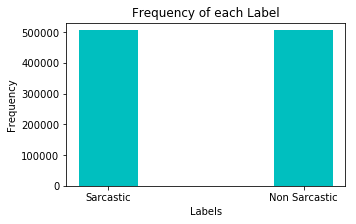

In [162]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
# data to plot
values = [data.groupby('label').agg('count').comment[1], 
          data.groupby('label').agg('count').comment[0]]
labels = ['Sarcastic', 'Non Sarcastic']

label_pos = [i for i, _ in enumerate(labels)]

# create plot
fig, ax = plt.subplots(figsize=(5, 3))
plt.bar(label_pos, values, color = 'c', width=0.3)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of each Label')
plt.xticks(label_pos, labels)

plt.show()

In [161]:
data_2.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
-1     26186.0  14419.248453  8344.231889   1.0  7187.25  14483.5  21691.75   
 1      2573.0  13980.559658  7851.490657  21.0  7229.00  13401.0  19976.00   

                
           max  
label           
-1     28759.0  
 1     28757.0

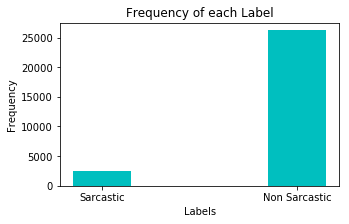

In [163]:
# Explore distribution of the data by label (-1 -> non-sarcastic, 1 -> sarcastic)
# data to plot
values = [data_2.groupby('label').agg('count').id[1], 
          data_2.groupby('label').agg('count').id[-1]]
labels = ['Sarcastic', 'Non Sarcastic']

label_pos = [i for i, _ in enumerate(labels)]

# create plot
fig, ax = plt.subplots(figsize=(5, 3))
plt.bar(label_pos, values, color = 'c', width=0.3)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of each Label')
plt.xticks(label_pos, labels)

plt.show()

We really wanted to use the entire dataset, unfortunately our laptops weren't strong enough to perform the different types of data manipulation and analysis we wanted. 
As a solution, we decided to sample 10% of the dataset each time we ran the program. 10% was actually the largest sample we could get without our Jupyter kernel dying from overflowing Docker's allocated memory resources (we set the memory for Docker to the max value possible given our laptops' specs!). 

In [61]:
data.drop(data[data.comment =='You forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot the'].index, inplace=True)
data.drop(data[data.comment =='you dropped this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped this:'].index, inplace=True)
data.drop(data[data.comment =='Forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot'].index, inplace=True)
data.drop(data[data.comment =='You forgot your'].index, inplace=True)
data.drop(data[data.comment =='You dropped this'].index, inplace=True)
data.drop(data[data.comment =='I think you forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped your'].index, inplace=True)
data.drop(data[data.comment =='I forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot'].index, inplace=True)

In [62]:
# Determine size and replacement values
size = int(len(data)*0.5/100)# sample size
replace = True  # with replacement
# Function used to pick random rows from the dataset
# We used the groupby('label') function to choose equal numbers 
# of sarcastic and non-sarcastic comments
fun = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
chosen_data = data.groupby('label', as_index=False).apply(fun)
chosen_data.head()

label                                            comment  \
0 12836       0                                    thank mr kelmon   
  191382      0                         PLEASE STOP REPOSTING THIS   
  197173      0             YOU ARE HAVING AN AUTOMOBILE ACCIDENT.   
  404430      0        Supertube has always worked for me as well.   
  790533      0  Wholly ridiculous name for a drop-dead *gorgeo...   

                                             parent_comment  
0 12836   Hey, guise, I have this really original meme. ...  
  191382    Zeus is the next god to get redesign (probably)  
  197173       That's some I, Robot level shit right there.  
  404430  Ahm, fasttube works well, buolt for BB10. You ...  
  790533                                          LaFerrari

In [63]:
# Select equal number of sarcastic and non-sarcastic comments
# Determine size and replacement values
size = 2573# sample size of each group being selected
replace = True  # with replacement
data_2 = data_2.groupby('label', as_index=False).apply(fun)
data_2.head()

id                                               text  label
0 5756    5757   They universally stood out in every environment.     -1
  6418    6419                                  That's a tantrum.     -1
  8281    8282                    No one cares about you anymore.     -1
  2546    2547            What does this have to do with divorce?     -1
  24045  24046   Don't think about how she was inundated and b...     -1

In [64]:
# CSV file: Reset the indexes to remove the grouping into 0s and 1s
chosen_data.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
chosen_data.drop(['level_0', 'level_1'], inplace = True, axis = 1)
chosen_data.head()

,label,comment,parent_comment
0,0,thank mr kelmon,"Hey, guise, I have this really original meme. ..."
1,0,PLEASE STOP REPOSTING THIS,Zeus is the next god to get redesign (probably)
2,0,YOU ARE HAVING AN AUTOMOBILE ACCIDENT.,"That's some I, Robot level shit right there."
3,0,Supertube has always worked for me as well.,"Ahm, fasttube works well, buolt for BB10. You ..."
4,0,Wholly ridiculous name for a drop-dead *gorgeo...,LaFerrari


In [65]:
# DB data: Reset the indexes to remove the grouping into -1s and 1s
data_2.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
data_2.drop(['level_0', 'level_1'], inplace = True, axis = 1)
data_2.head()

,id,text,label
0,5757,They universally stood out in every environment.,-1
1,6419,That's a tantrum.,-1
2,8282,No one cares about you anymore.,-1
3,2547,What does this have to do with divorce?,-1
4,24046,Don't think about how she was inundated and b...,-1


In [66]:
data.groupby('label').describe()

comment                    parent_comment                     
        count  unique   top freq          count  unique     top freq
label                                                               
0      505405  479850   Yes  406         505405  495453  me irl  228
1      501218  486344  Who?  149         501218  491218    Why?  147

In [67]:
data_2.groupby('label').describe()

id                                                             \
        count          mean          std   min     25%      50%      75%   
label                                                                      
-1     2573.0  14645.260785  8271.207496   1.0  7287.0  14934.0  21767.0   
 1     2573.0  13743.355616  7798.330468  21.0  7072.0  13072.0  19675.0   

                
           max  
label           
-1     28759.0  
 1     28719.0

Part 3: Exploratory Analysis & Data Visualization

We made sure we got equal number of sarcastic and non-sarcastic comments. From the following histogram, we notice we got 50,000 comments from each group.

In [122]:
# data_2.groupby('label').agg('count').id[-1]
chosen_data.groupby('label').agg('count').comment[1]

5033

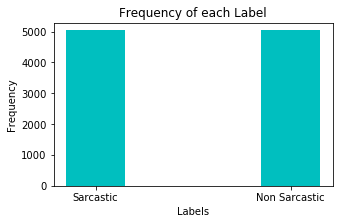

In [152]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
# data to plot
values = [chosen_data.groupby('label').agg('count').comment[1], 
          chosen_data.groupby('label').agg('count').comment[0]]
labels = ['Sarcastic', 'Non Sarcastic']

label_pos = [i for i, _ in enumerate(labels)]

# create plot
fig, ax = plt.subplots(figsize=(5, 3))
plt.bar(label_pos, values, color = 'c', width=0.3)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of each Label')
plt.xticks(label_pos, labels)

plt.show()

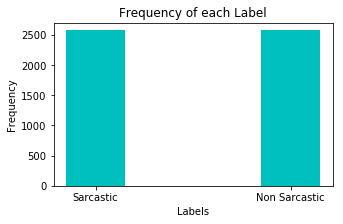

In [154]:
# Explore distribution of the data by label (-1 -> non-sarcastic, 1 -> sarcastic)
# plt.hist(data_2.label)
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.title('Distribution of Comments by Label')
# plt.show()

# Explore distribution of the data by label (-1 -> non-sarcastic, 1 -> sarcastic)
# data to plot
values = [data_2.groupby('label').agg('count').id[1], 
          data_2.groupby('label').agg('count').id[-1]]
labels = ['Sarcastic', 'Non Sarcastic']

label_pos = [i for i, _ in enumerate(labels)]

# create plot
fig, ax = plt.subplots(figsize=(5, 3))
plt.bar(label_pos, values, color = 'c', width=0.3)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of each Label')
plt.xticks(label_pos, labels)

plt.show()

In [70]:
# Import NLTK library
!pip install nltk

In [71]:
import nltk

In [72]:
# nltk.download("all")

In [73]:
from nltk.corpus import stopwords #Use this to get rid of meaningless words like "the, and, a"
from nltk.tokenize import word_tokenize #Split by word
from nltk.tokenize import sent_tokenize #Split by sentence

In [223]:
#Make sure all the comment column is str data type
chosen_data['comment'] = chosen_data['comment'].astype(str)
chosen_data['parent_comment'] = chosen_data['parent_comment'].astype(str)
data_2['text'] = data_2['text'].astype(str)

# Split the comments into words
chosen_data['tok_comment'] = chosen_data['comment'].apply(word_tokenize)
data_2['tok_comment'] = data_2['text'].apply(word_tokenize)
# Apply Parts of Speech tagging on the words
chosen_data['POS_tag'] = chosen_data['tok_comment'].apply(nltk.pos_tag)
data_2['POS_tag'] = data_2['tok_comment'].apply(nltk.pos_tag)
# chosen_data.head()

# Apply stemming on the tokenized comments to get the roots of the words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

chosen_data['stem'] = chosen_data['tok_comment'].apply(lambda x: [stemmer.stem(y) for y in x])
data_2['stem'] = data_2['tok_comment'].apply(lambda x: [stemmer.stem(y) for y in x])


After confirming our suspicions that using TF-IDF on the raw tokenized comments would yield very modest results, we decided to continue exploring how we can fix our models. First, we used chunking to break up the comments into more meaningful noun phrases. 

Notice how the chunked sentences column groups the nouns into groups with

In [224]:
joined_tag = []
for index, row in chosen_data.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
chosen_data['joined_POS_tag'] = joined_tag.copy()

# For DB data
joined_tag = []
for index, row in data_2.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
data_2['joined_POS_tag'] = joined_tag.copy()


In [225]:
!pip install -U textblob
from textblob import TextBlob

Requirement already up-to-date: textblob in /opt/conda/lib/python3.7/site-packages (0.15.3)


In [226]:

# Polarity for comment
blob_list = []
for index, row in chosen_data.iterrows():
    blob_list.append(TextBlob(row['comment']))
chosen_data['textblob'] = blob_list.copy()

# chosen_data.head()

polarity_list = []
for index, row in chosen_data.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

chosen_data['polarity'] = polarity_list.copy()

# chosen_data.head()

# print(chosen_data['polarity'].shape)

In [227]:
# Polarity for parent comment

parent_blob_list = []
for index, row in chosen_data.iterrows():
    parent_blob_list.append(TextBlob(row['parent_comment']))
chosen_data['parent_textblob'] = parent_blob_list.copy()


# chosen_data.head()

parent_polarity_list = []
for index, row in chosen_data.iterrows():
    parent_polarity_list.append(row['parent_textblob'].sentiment.polarity)

chosen_data['parent_polarity'] = parent_polarity_list.copy()

# chosen_data.head()

# print(chosen_data['parent_polarity'].shape)

In [228]:
# Polarity for comment
blob_list = []
for index, row in data_2.iterrows():
    blob_list.append(TextBlob(row['text']))
data_2['textblob'] = blob_list.copy()

# chosen_data.head()

polarity_list = []
for index, row in data_2.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

data_2['polarity'] = polarity_list.copy()

# print(data_2['polarity'].shape)
# data_2.head()

In [229]:

chosen_data['joined_stem'] = chosen_data['stem'].apply(lambda x: ' '.join(x))
data_2['joined_stem'] = data_2['stem'].apply(lambda x: ' '.join(x))
# chosen_data.head()

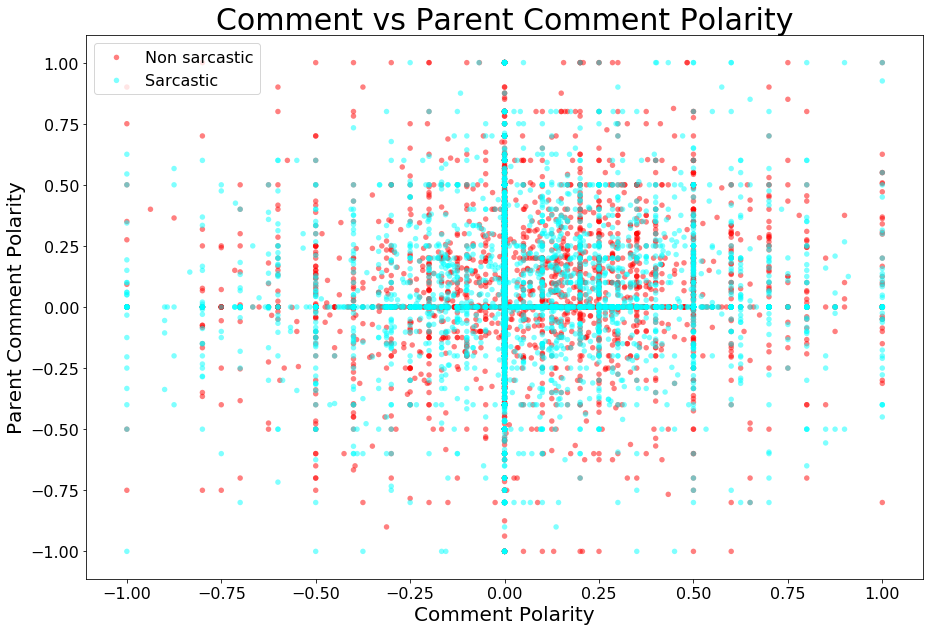

In [220]:
# chosen_data.groupby('label').get_group(0)['polarity']
g1 = (chosen_data.groupby('label').get_group(0)['polarity'],
     chosen_data.groupby('label').get_group(0)['parent_polarity'])

g2 = (chosen_data.groupby('label').get_group(1)['polarity'],
     chosen_data.groupby('label').get_group(1)['parent_polarity'])

data = (g1, g2)
colors = ("red", "cyan")
groups = ('Non sarcastic', 'Sarcastic')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha = 0.5, c = color, 
               edgecolors = 'none', s = 30, label = group)
    
plt.title("Comment vs Parent Comment Polarity", fontsize = 30)
plt.xlabel("Comment Polarity", fontsize = 20)
plt.ylabel("Parent Comment Polarity", fontsize = 20)
plt.legend(loc = 2)
plt.show()

In [230]:
data_2.head()

,id,text,label,tok_comment,POS_tag,stem,joined_POS_tag,textblob,polarity,joined_stem
0,1,I suspect atheists are projecting their desire...,-1,"[I, suspect, atheists, are, projecting, their,...","[(I, PRP), (suspect, VBP), (atheists, NNS), (a...","[i, suspect, atheist, are, project, their, des...",I_PRP suspect_VBP atheists_NNS are_VBP project...,"(I, , s, u, s, p, e, c, t, , a, t, h, e, i, ...",0.0,i suspect atheist are project their desir when...
1,2,Does anyone remember the crazy preacher with ...,-1,"[Does, anyone, remember, the, crazy, preacher,...","[(Does, NNP), (anyone, NN), (remember, VB), (t...","[doe, anyon, rememb, the, crazi, preacher, wit...",Does_NNP anyone_NN remember_VB the_DT crazy_NN...,"( , D, o, e, s, , a, n, y, o, n, e, , r, e, ...",-0.6,doe anyon rememb the crazi preacher with whom ...
2,3,\nhttp://www.,-1,"[http, :, //www, .]","[(http, NN), (:, :), (//www, NN), (., .)]","[http, :, //www, .]",http_NN :_: //www_NN ._.,"(\n, h, t, t, p, :, /, /, w, w, w, .)",0.0,http : //www .
3,4,examiner.,-1,"[examiner, .]","[(examiner, NN), (., .)]","[examin, .]",examiner_NN ._.,"(e, x, a, m, i, n, e, r, .)",0.0,examin .
4,5,com/article/obama-and-wright-throw-each-other-...,-1,[com/article/obama-and-wright-throw-each-other...,[(com/article/obama-and-wright-throw-each-othe...,[com/article/obama-and-wright-throw-each-other...,com/article/obama-and-wright-throw-each-other-...,"(c, o, m, /, a, r, t, i, c, l, e, /, o, b, a, ...",0.5,com/article/obama-and-wright-throw-each-other-...


### Predicting Sarcasm

We were interested in trying different models for predicting a sarcastic comment.
To determine the features and labels for the analysis, we decided to look at the comment itself as a feature and use the given sarcastic vs non-sarcastic classification as our label.

Various articles and studies looked at sarcasm and attempted to predict using different features. For instance, an online tutorial only looked at TF-IDF as a feature, so we decided we wanted to experiment with that and see if we would get anything remotely close to their findings. Worth noting, however, that they looked at tweets with the #sarcasm tag, their dataset was significantly smaller than ours (N= ), and their training vs test data split was slightly unusual (training = 95%, test = 5%). 

To create a more reliable model, we decided to split our data into the more common 80-20 split for training and test subsets respectively. We also chose three main models to compare, acknowledging that some of them might fare slightly more poorly compared to the others. We also assumed TF-IDF vectorization of the comments alone would not be a good predictor for whether a comment is sarcastic or not. 

The three models we picked were:
1. Logistic regression
2. Support Vector Machine
3. Random forest

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [82]:
X_train, X_test, y_train, y_test = train_test_split(chosen_data[['joined_POS_tag', 'joined_stem', 'polarity', 'parent_polarity']] , chosen_data.label, test_size=0.2, random_state=0)
X_train.head()

,joined_POS_tag,joined_stem,polarity,parent_polarity
787,I_PRP heard_VBD old_JJ one_CD eye_NN is_VBZ pr...,i heard old one eye is pretti cute though ; ),0.275,0.3375
4007,Better_NNP off_RP by_IN using_VBG your_PRP$ ma...,better off by use your mana to poke with q thr...,0.625,-0.2500
3188,Electric_NNP Universe_NNP Theory_NNP,electr univers theori,0.000,-0.1000
4763,I_PRP would_MD stay_VB away_RB from_IN this_DT...,i would stay away from this with a barg pole .,0.000,0.0000
8120,So_IN she_PRP was_VBD concerned_VBN that_IN sh...,so she was concern that she ll miss her flight...,0.125,0.0000


In [83]:
# For the database
db_X_train, db_X_test, db_y_train, db_y_test = train_test_split(data_2[['joined_POS_tag', 'joined_stem', 'polarity']] , data_2.label, test_size=0.2, random_state=0)
db_X_train.head()

,joined_POS_tag,joined_stem,polarity
1936,What_WP ever_RB happened_VBD to_TO privacy_VB ...,"what ever happen to privaci , or to mind your ...",0.600000
2509,``_`` Of_IN course_NN Democrats_NNPS are_VBP n...,`` of cours democrat are not fight like hell f...,-0.071429
872,There_EX is_VBZ no_DT way_NN to_TO 'harvest_VB...,there is no way to harvest ' energi from radio...,-0.300000
831,Will_MD someone_NN throw_VB water_NN on_IN thi...,will someon throw water on this bitch so she w...,0.000000
1813,For_IN them_PRP to_TO make_VB ``_`` This_DT as...,for them to make `` this as pain as possibl ''...,-0.233333


In [84]:
# TF-IDF to vectorize the data
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
stem_vectorizer = TfidfVectorizer(ngram_range = (1,3)) # ask about max features
tfidf_stem = stem_vectorizer.fit_transform(X_train.joined_stem)

pos_vectorizer = TfidfVectorizer(ngram_range = (1,3))
tfidf_pos = pos_vectorizer.fit_transform(X_train.joined_POS_tag)

combined_2 = sp.hstack([tfidf_stem, tfidf_pos], format = 'csr')
combined_3 = sp.hstack((combined_2,np.array(X_train.polarity)[:,None]))
combined_4 = sp.hstack((combined_3,np.array(X_train.parent_polarity)[:,None]))

# test_stem_vectorizer = TfidfVectorizer(max_features = 10000) # ask about max features
test_tfidf_stem = stem_vectorizer.transform(X_test.joined_stem)

# test_pos_vectorizer = TfidfVectorizer(max_features = 10000)
test_tfidf_pos = pos_vectorizer.transform(X_test.joined_POS_tag)

test_combined_2 = sp.hstack([test_tfidf_stem, test_tfidf_pos], format = 'csr')
test_combined_2.shape

test_combined_3 = sp.hstack((test_combined_2,np.array(X_test.polarity)[:,None]))
test_combined_4 = sp.hstack((test_combined_3,np.array(X_test.parent_polarity)[:,None]))

In [85]:
db_stem_vectorizer = TfidfVectorizer(ngram_range = (1,3)) # ask about max features
db_tfidf_stem = db_stem_vectorizer.fit_transform(db_X_train.joined_stem)

db_pos_vectorizer = TfidfVectorizer(ngram_range = (1,3))
db_tfidf_pos = db_pos_vectorizer.fit_transform(db_X_train.joined_POS_tag)

db_combined_2 = sp.hstack([db_tfidf_stem, db_tfidf_pos], format = 'csr')

db_combined_3 = sp.hstack((db_combined_2,np.array(db_X_train.polarity)[:,None]))

## Test data vectorizing

# test_stem_vectorizer = TfidfVectorizer(max_features = 10000) # ask about max features
db_test_tfidf_stem = db_stem_vectorizer.transform(db_X_test.joined_stem)

# test_pos_vectorizer = TfidfVectorizer(max_features = 10000)
db_test_tfidf_pos = db_pos_vectorizer.transform(db_X_test.joined_POS_tag)

db_test_combined_2 = sp.hstack([db_test_tfidf_stem, db_test_tfidf_pos], format = 'csr')
db_test_combined_2.shape

db_test_combined_3 = sp.hstack((db_test_combined_2,np.array(db_X_test.polarity)[:,None]))

In [86]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(combined_4, y_train)

# Logistic regression score
print("Training score: ", log_clf.score(combined_4, y_train))
print("Test score: ", log_clf.score(test_combined_4, y_test))

# Logistic Regression

cv_log_clf = LogisticRegressionCV(cv = 5, solver='lbfgs', max_iter = 300).fit(combined_4, y_train)

# Logistic regression score
print("Training score: ", cv_log_clf.score(combined_4, y_train))
print("Test score: ", cv_log_clf.score(test_combined_4, y_test))

Training score:  0.9901887729756582
Test score:  0.6444885799404171
Training score:  0.9967709885742673
Test score:  0.6420059582919563


In [87]:
# Logistic Regression for DB data

db_log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(db_combined_3, db_y_train)

# Logistic regression score
print("Training score: ", db_log_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_log_clf.score(db_test_combined_3, db_y_test))

# Logistic Regression for DB data

cv_db_log_clf = LogisticRegressionCV(cv=5,solver='lbfgs', max_iter = 500).fit(db_combined_3, db_y_train)

# Logistic regression score
print("Training score: ", cv_db_log_clf.score(db_combined_3, db_y_train))
print("Test score: ", cv_db_log_clf.score(db_test_combined_3, db_y_test))



Training score:  0.9849368318756074
Test score:  0.7436893203883496
Training score:  0.9868804664723032
Test score:  0.7495145631067961


In [88]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(combined_4, y_train)

print("Training score: ", svm_clf.score(combined_4, y_train))
print("Test score: ", svm_clf.score(test_combined_4, y_test))

Training score:  0.9973919523099851
Test score:  0.6395233366434955


In [89]:
# SVM model
db_svm_clf = LinearSVC()

# Training the model
db_svm_clf.fit(db_combined_3, db_y_train)

print("Training score: ", db_svm_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_svm_clf.score(db_test_combined_3, db_y_test))

Training score:  0.9871234207968902
Test score:  0.7514563106796116


In [90]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 100)

rf_clf.fit(combined_4, y_train)

print("Training score: ", rf_clf.score(combined_4, y_train))
print("Test score: ", rf_clf.score(test_combined_4, y_test))

Training score:  0.9991306507699951
Test score:  0.6206554121151936


In [91]:
# Random Forest Classifier

db_rf_clf = RandomForestClassifier(n_estimators = 100)

db_rf_clf.fit(db_combined_3, db_y_train)

print("Training score: ", db_rf_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_rf_clf.score(db_test_combined_3, db_y_test))

Training score:  0.989067055393586
Test score:  0.6990291262135923


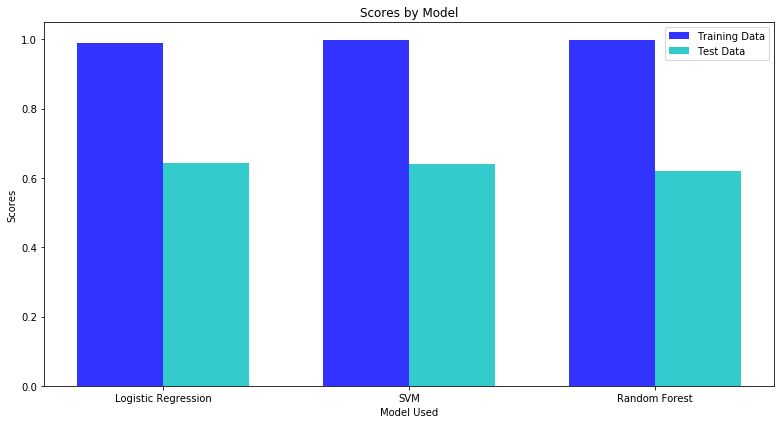

In [92]:
# data to plot
n_groups = 3
train_score = [log_clf.score(combined_4, y_train), 
          svm_clf.score(combined_4, y_train),
          rf_clf.score(combined_4, y_train)]
test_score = [log_clf.score(test_combined_4, y_test), 
          svm_clf.score(test_combined_4, y_test),
          rf_clf.score(test_combined_4, y_test)]

# create plot
fig, ax = plt.subplots(figsize=(11, 6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_score, bar_width,
alpha=opacity,
color='b',
label='Training Data')

rects2 = plt.bar(index + bar_width, test_score, bar_width,
alpha=opacity,
color='c',
label='Test Data')

plt.xlabel('Model Used')
plt.ylabel('Scores')
plt.title('Scores by Model')
plt.xticks(index + bar_width/2, ('Logistic Regression', 'SVM', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

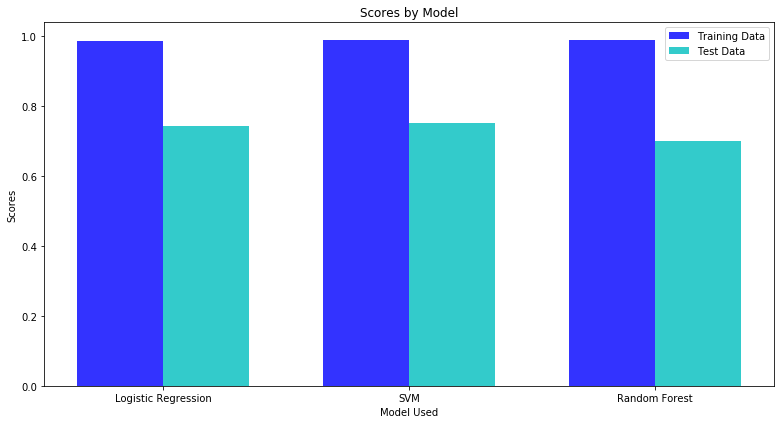

In [93]:
# data to plot
n_groups = 3
train_score = [db_log_clf.score(db_combined_3, db_y_train), 
          db_svm_clf.score(db_combined_3, db_y_train),
          db_rf_clf.score(db_combined_3, db_y_train)]
test_score = [db_log_clf.score(db_test_combined_3, db_y_test), 
          db_svm_clf.score(db_test_combined_3, db_y_test),
          db_rf_clf.score(db_test_combined_3, db_y_test)]

# create plot
fig, ax = plt.subplots(figsize=(11, 6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_score, bar_width,
alpha=opacity,
color='b',
label='Training Data')

rects2 = plt.bar(index + bar_width, test_score, bar_width,
alpha=opacity,
color='c',
label='Test Data')

plt.xlabel('Model Used')
plt.ylabel('Scores')
plt.title('Scores by Model')
plt.xticks(index + bar_width/2, ('Logistic Regression', 'SVM', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()